# Data handling, exploration and pca 

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

from linearmodels import OLS

import time

In [2]:
df = pd.read_csv('used.csv', index_col=0)
#df2 = pd.read_csv('original.csv',index_col=0)

In [3]:
df.head()

,SN_2,Questionnaire,gn,ds,District,Province,A1_1,A1_2,A1_3,A1_4,...,trust_eth,reconcile1,reconcile2,reconcile2add,reconcile1add,tol_buddhist,tol_christ,prewar,rights_sinhaleseALL,ethnic2
1,1,1,32,33,3,1,1,2.0,3.0,5.0,...,2.0,1.559590,-0.047157,1.5,2.5,NaN,NaN,0,3.0,2.0
2,2,1,32,33,3,1,1,2.0,3.0,3.0,...,2.0,0.038614,-0.125119,1.5,1.5,NaN,NaN,0,3.0,2.0
3,3,1,32,33,3,1,1,2.0,3.0,3.0,...,2.0,0.311233,-0.532862,1.5,1.5,NaN,NaN,0,2.0,2.0
4,4,1,32,33,3,1,1,2.0,3.0,3.0,...,2.0,0.038614,-0.125119,1.5,1.5,NaN,NaN,0,2.0,2.0
5,5,1,32,33,3,1,1,2.0,3.0,3.0,...,1.0,-0.982462,-0.235567,1.5,1.0,NaN,NaN,0,2.0,2.0


In [4]:
# sem (distress <- war gender age edu eduf) 
# (growth1 <- distress war )
# (growth2 <- distress war )
# (rights_sinhalese <- war distress growth1 growth2 gender age edu eduf), 
# stand
# cov(e.distress*e.growth1)
# cov(e.distress*e.growth2)
# cov(e.growth1*e.growth2)
# ;
# #delimit cr 
# estat gof, stats(indices residuals)

In [35]:
# for i in df.columns:
#     print(i)

In [ ]:
# growth
# growthf1
# growthf2
# growth1factor
# growth2factor
# growth1
# growth2

In [75]:
# df['my_growth1']=(df['E2a']+df['E2c']+df['E2f']+df['E2g']+df['E2i']+df['E2j'])/6
# df['my_growth2']=(df['E2b']+df['E2d']+df['E2e']+df['E2h'])/4

In [18]:
# men har du kun termiler her?
#keep if tamil2==1 Carolin
#df_carolin = df[df['tamil2']==1][['rights_sinhalese','distress','war','gender','age','edu','eduf','growth1', 'growth2']].dropna().copy()

df_carolin = Es_non_norm = df[df['tamil2']==1][['rights_sinhalese','distress','war','gender','age','edu','eduf','growth1', 'growth2',
                                  'E2a','E2c','E2f','E2g','E2i','E2j','E2b','E2d','E2e','E2h']].dropna().copy()

# full additive index
df_carolin['growth_full'] = (df_carolin['E2a']+df_carolin['E2c']+df_carolin['E2f']+df_carolin['E2g']+
                             df_carolin['E2i']+df_carolin['E2j'] + df_carolin['E2b']+df_carolin['E2d']+
                             df_carolin['E2e']+df_carolin['E2h'])/10


#df_carolin = df[['rights_sinhalese','distress','war','gender','age','edu','eduf','growth1', 'growth2']].copy()

#religiosity
df_carolin.shape

(359, 20)

In [ ]:
# Model1 Carolins model

In [5]:
# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
X2 = df_carolin['growth1']
X3 = df_carolin['growth2']

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Target
Y = df_carolin['rights_sinhalese']

In [9]:
model1 = pm.Model()

with model1:

#     # Priors for unknown model parameters

    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 4)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
    beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
    beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)
    
    beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
    beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
    beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
    beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)

    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4)

    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4)
    
    sigma = pm.HalfNormal('sigma', sd=1, shape=4)#A vector of error-terms

    

    # Expected value of outcome
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
    mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
    X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
    mu3 = alpha[2] + beta03 * X0 + beta13 * X1_obs
    X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[2], observed=X3)
    
    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    Y_obs = pm.Normal('Y_obs', mu=mu4, sd=sigma[3], observed=Y)


In [26]:
with model1:
    # draw 500 posterior samples
    trace1 = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(trace1).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma4, gamma1, beta24, beta14, beta04, beta12, beta02, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:07<00:00, 62.65draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.516,0.380,0.006,-0.190,1.277,4030.861,1.001
alpha__1,2.594,0.139,0.002,2.322,2.871,5226.661,1.000
alpha__2,-0.085,10.290,0.113,-20.844,20.147,7940.596,1.000
alpha__3,1.585,0.276,0.004,1.045,2.113,4498.023,1.000
beta01__0,0.213,0.086,0.001,0.047,0.380,5422.787,1.000
beta02__0,0.228,0.053,0.001,0.126,0.334,5427.598,1.000
beta12__0,0.069,0.032,0.000,0.010,0.132,7856.363,1.000
beta04__0,-0.146,0.053,0.001,-0.249,-0.043,5424.308,1.000
beta14__0,-0.065,0.031,0.000,-0.127,-0.003,6611.611,1.000
beta24__0,-0.057,0.051,0.001,-0.158,0.041,5562.327,1.000


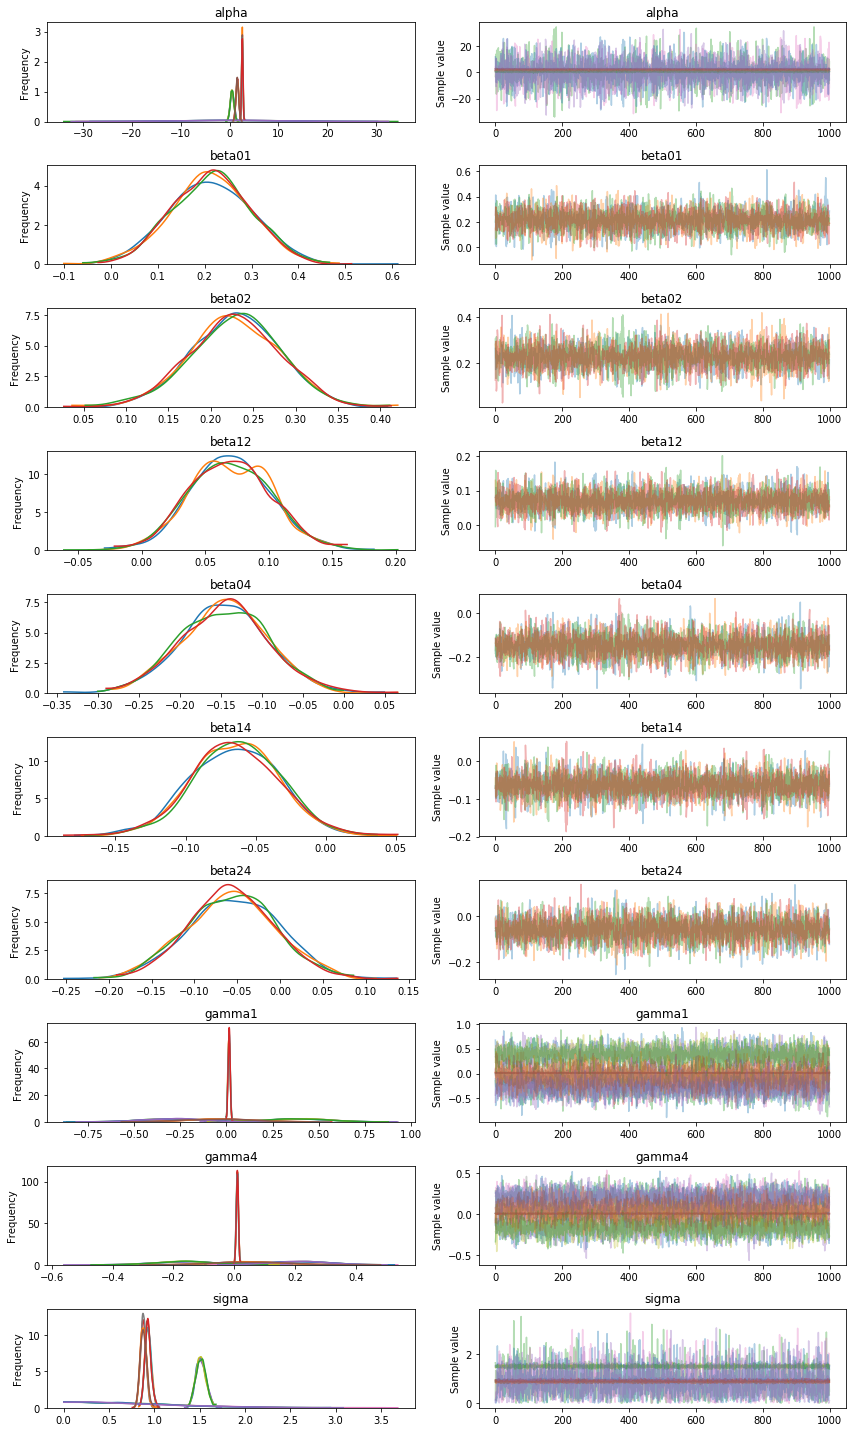

In [27]:
pm.traceplot(trace1)
plt.show()

In [ ]:
# Hvorfor den vej for beta12 og beta13?

In [ ]:
# Det er alt sammen meget mærkeligt...

# model 2: one growth dimension:

In [78]:
# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
X2 = df_carolin['growth_full']
#X2 = df_carolin['growth1']
#X3 = df_carolin['growth2']

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Target
Y = df_carolin['rights_sinhalese']

In [79]:
model2 = pm.Model()

with model2:

#     # Priors for unknown model parameters

    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 3)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
    beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
    beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)
    
#     beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
#     beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
    beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
#     beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)

    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4)

    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4)
    
    sigma = pm.HalfNormal('sigma', sd=1, shape=3)#A vector of error-terms

    

    # Expected value of outcome
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
    mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
    X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
#     mu3 = alpha[2] + beta03 * X0 + beta13 * X1_obs
#     X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[2], observed=X3)
    
#    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    mu4 = alpha[2] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3

    Y_obs = pm.Normal('Y_obs', mu=mu4, sd=sigma[2], observed=Y)


In [80]:
with model2:
    # draw 500 posterior samples
    trace2 = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(trace2).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma4, gamma1, beta24, beta14, beta04, beta12, beta02, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:43<00:00, 77.18draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.532,0.389,0.006,-0.243,1.266,3496.725,1.0
alpha__1,2.592,0.140,0.002,2.329,2.878,4505.971,1.0
alpha__2,1.598,0.273,0.005,1.053,2.108,3552.156,1.0
beta01__0,0.211,0.089,0.001,0.041,0.384,5441.114,1.0
beta02__0,0.229,0.053,0.001,0.128,0.337,4578.033,1.0
beta12__0,0.069,0.031,0.000,0.009,0.131,6899.943,1.0
beta04__0,-0.148,0.051,0.001,-0.257,-0.055,6954.389,1.0
beta14__0,-0.064,0.031,0.000,-0.124,-0.005,6587.115,1.0
beta24__0,-0.057,0.052,0.001,-0.162,0.040,4617.898,1.0
gamma1__0,0.378,0.174,0.002,0.050,0.713,5302.168,1.0


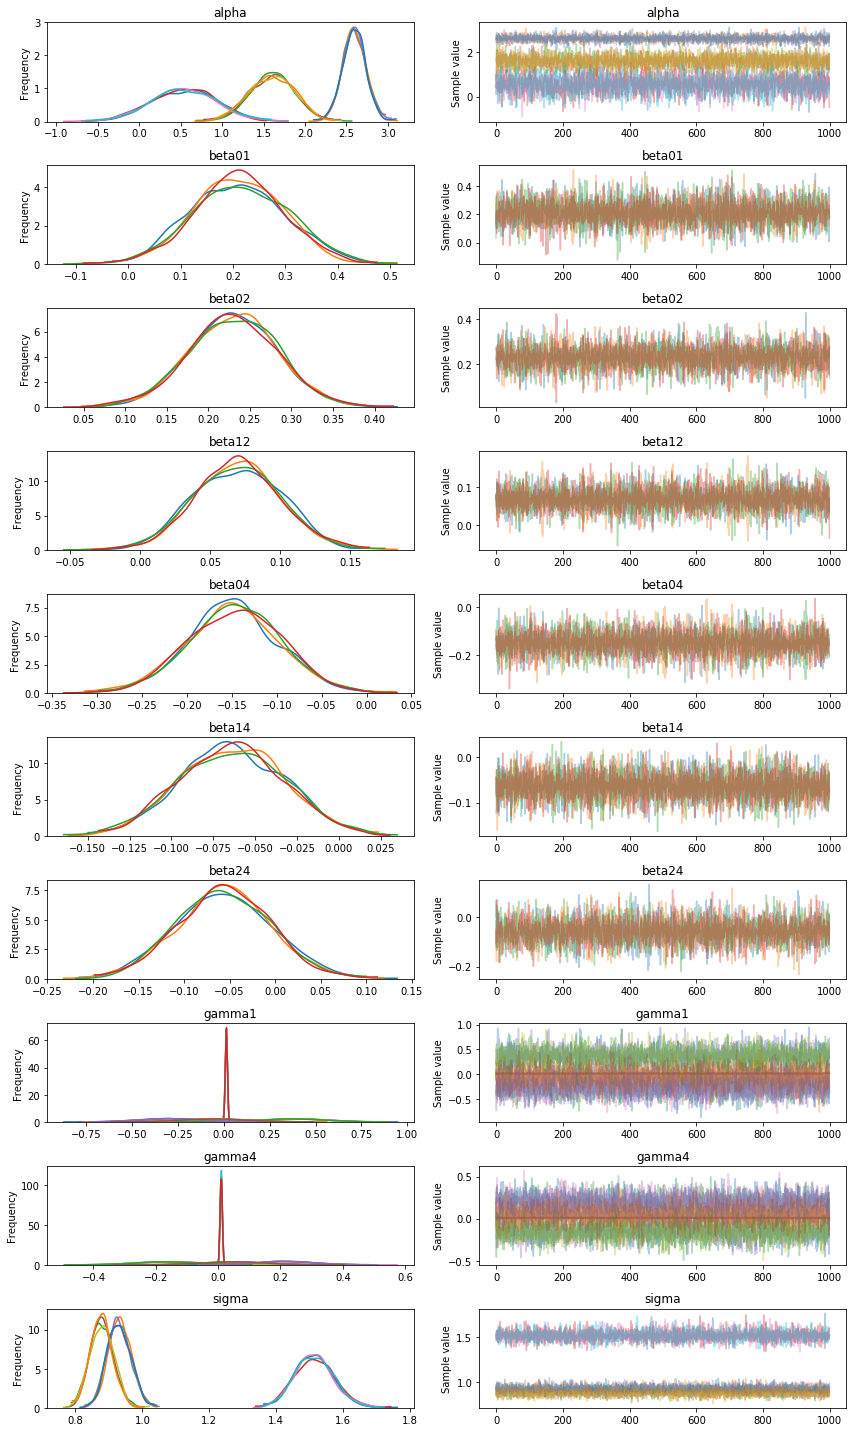

In [81]:
pm.traceplot(trace2)
plt.show()

# model 3 - no growth

In [64]:
# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
#X2 = df_carolin['growth_full']
#X2 = df_carolin['growth1']
#X3 = df_carolin['growth2']

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Target
Y = df_carolin['rights_sinhalese']

In [94]:
model3 = pm.Model()

with model3:

#     # Priors for unknown model parameters

    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 3)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
#     beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
#     beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)
    
    beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
#     beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
#     beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
#     beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)

    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4)

    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4)
    
    sigma = pm.HalfNormal('sigma', sd=1, shape=3)#A vector of error-terms

    

    # Expected value of outcome
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
#     mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
#     X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
    mu3 = alpha[1] + beta03 * X0 #+ beta13 * X1_obs
    X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[1], observed=X3) # is'nt used just here to allow comparison...
    
#    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
#    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    mu4 = alpha[2] + beta14 * X1_obs + beta04 * X0 + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3

    Y_obs = pm.Normal('Y_obs', mu=mu4, sd=sigma[2], observed=Y)


In [95]:
with model3:
    # draw 500 posterior samples
    trace3 = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(trace3).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma4, gamma1, beta14, beta04, beta03, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:06<00:00, 70.66draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.528,0.405,0.007,-0.282,1.290,3049.180,1.000
alpha__1,2.730,0.154,0.003,2.444,3.042,3086.961,1.000
alpha__2,1.427,0.233,0.004,1.001,1.915,2880.797,1.001
beta01__0,0.211,0.090,0.001,0.039,0.395,3978.185,1.000
beta03__0,0.209,0.060,0.001,0.085,0.318,3113.594,1.001
beta04__0,-0.160,0.052,0.001,-0.262,-0.058,3988.754,1.000
beta14__0,-0.070,0.031,0.000,-0.131,-0.012,4942.443,1.000
gamma1__0,0.383,0.174,0.003,0.041,0.721,4871.325,1.000
gamma1__1,0.014,0.006,0.000,0.004,0.026,3539.655,1.000
gamma1__2,-0.298,0.160,0.003,-0.611,0.019,3750.134,1.000


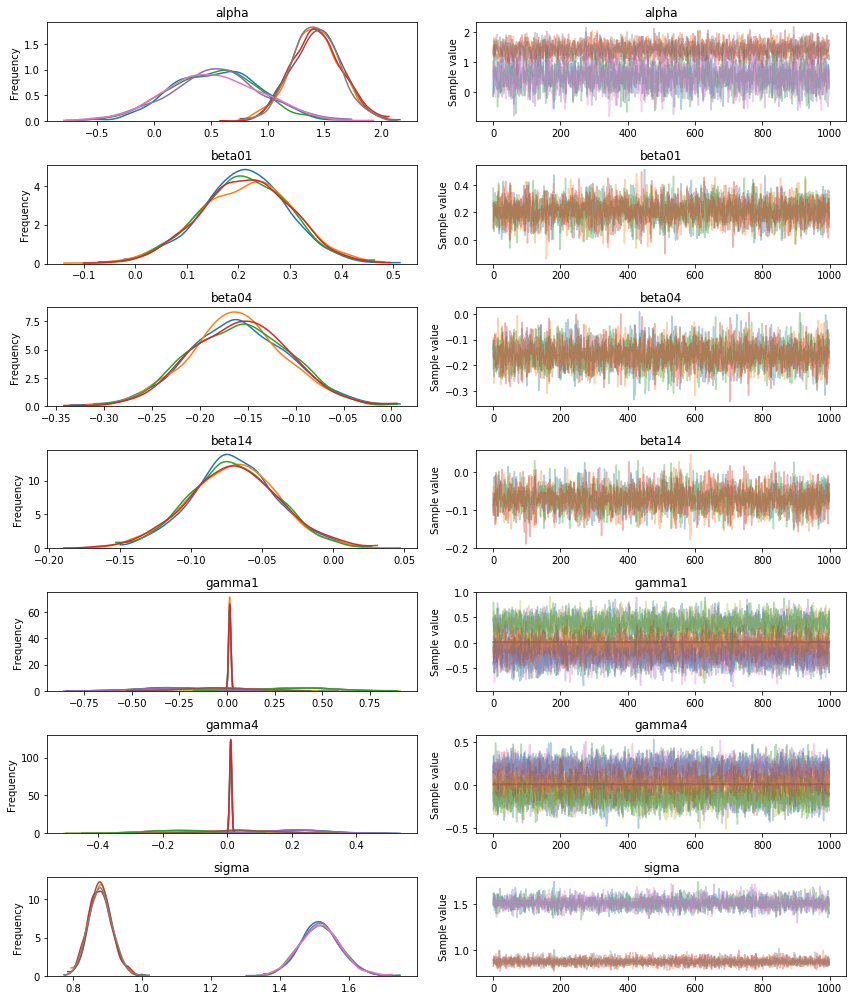

In [76]:
pm.traceplot(trace3)
plt.show()

# compare:

In [97]:
pm.compare({model1:trace1,model2:trace2,model3:trace3})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,3227.76,18.43,0,1,38.21,0,0
0,3227.86,18.5,0.1,0,38.16,0.22,0
2,3336.4,16.47,108.64,0,37.8,19.88,0
